In [76]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import pandas as pd
from classy import Class
from copy import deepcopy
import torch
import sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
import sys
from scipy import stats

#path_to_file = 'path/to/cosmoped'
path_to_file = '/Users/aisulu/Desktop/moped_sbi/cosmoped'
if path_to_file not in sys.path:
    sys.path.append(path_to_file)

from cosmoped_likelihood import CosMOPED

DEVICE = 'gpu' if torch.cuda.is_available() else 'cpu'

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 12

file_path = '/Users/aisulu/Desktop/report_code/noise_fake_planck_realistic_two.dat'

try:
    fpr = np.loadtxt(file_path)
except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print(f"An error occurred: {e}")

lmax=2500
fsky=1.0
ell=np.array([l for l in range(2,lmax+1)])
ells=ell*(ell+1)/(2*np.pi)

Nltt = fpr[ell-2,1]

In [77]:
path='/Users/aisulu/Desktop/report_code/LambdaCDM/'
TT2018=CosMOPED(path, year=2018, spectra='TT', use_low_ell_bins=False)

samples_store = np.load('/Users/aisulu/Desktop/report_code/samples_store.npy')
pars_store = np.load('/Users/aisulu/Desktop/report_code/pars_store.npy')


In [78]:
param_min = []
param_max = []

for i in range(5):
    minim = min(pars_store[:, i])
    maxim = max(pars_store[:, i])
    param_min.append(minim)
    param_max.append(maxim)

In [79]:
compression_vector_dict, compressed_data_dict = TT2018.read_compression_vectors_and_compressed_data(path)
compress_vec_h = compression_vector_dict['h'][:2499]
compress_vec_ombh2 = compression_vector_dict['omega_b'][:2499]
compress_vec_omch2 = compression_vector_dict['omega_cdm'][:2499]
compress_vec_As = compression_vector_dict['A_s'][:2499]
compress_vec_ns = compression_vector_dict['n_s'][:2499]

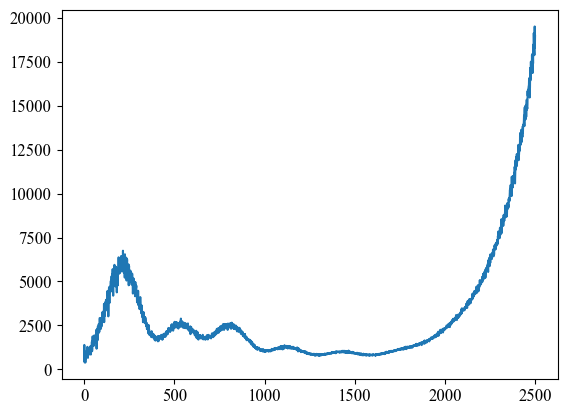

In [80]:
plt.plot(samples_store[0])

In [112]:
samples_compressed = []
for i in range(len(samples_store)):
    cltt = samples_store[i]/ells
    output = [compress_vec_h.dot(cltt), compress_vec_ombh2.dot(cltt), compress_vec_omch2.dot(cltt), compress_vec_As.dot(cltt),compress_vec_ns.dot(cltt)]
    samples_compressed.append(output)


In [114]:
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn
from sbi import utils as utils
from sbi import analysis as analysis

prior = utils.BoxUniform(low=torch.as_tensor(param_min),
                         high=torch.as_tensor(param_max))

inference = SNPE(prior=prior)

inference = inference.append_simulations(torch.tensor(pars_store, dtype = torch.float32), 
                                         torch.tensor(samples_compressed, dtype = torch.float32))

density_estimator = inference.train()

 Neural network successfully converged after 154 epochs.

In [88]:
def simulator(v):
    V=np.around(v, decimals=6)
    h, omega_b, omega_cdm, lnAs,n_s=V[0],V[1],V[2],V[3],V[4]
    A_s=np.exp(lnAs)/ 1.e10
    params = {
        'output': 'tCl pCl lCl',
        'l_max_scalars': lmax,
        'lensing': 'yes',
        'h': h,
        'omega_b': omega_b,
        'omega_cdm': omega_cdm,
        'A_s': A_s,
        'n_s': n_s,
    }
    cosmo = Class()
    cosmo.set(params)
    try:
        cosmo.compute(['lensing'])
        cls = cosmo.lensed_cl(lmax)
        T=cosmo.T_cmb()
        cosmo.struct_cleanup()
        cosmo.empty()
        return dict(TT=cls['tt'][ell]*(T*1.e6)**2+Nltt)
    except Exception as e:
        print("a simulation failed!")
        print(f"An error occurred: {e}")
        return dict(TT=np.nan)
    
pl=[0.676, 0.0224, 0.12, 3.0753, 0.965]
obs = simulator(pl)

covmat=np.diag(obs['TT']**2)*2/((2*ell+1)*fsky)
icovmat=np.linalg.inv(covmat)

noisevecs = np.random.multivariate_normal(np.zeros(2499),covmat,size=100000)

def noise(obs):
    cat = np.array(obs['TT'])
    CLTT=[]
    for l in range(2,2+49):
        nm=int(np.round(fsky*(2*l+1)))
        g1=np.random.randn(nm)
        almT=np.sqrt(obs['TT'][l-2])*g1
        CLTT.append((((nm))**-1 *np.sum((almT**2))))
    NN=noisevecs[np.random.randint(0,100000)]
    noise=np.concatenate((np.zeros(29+20), NN[29+20:2499]))
    cat[:49]=np.array(CLTT)
    cat=cat+noise
    return {'TT': cat[:2500]}

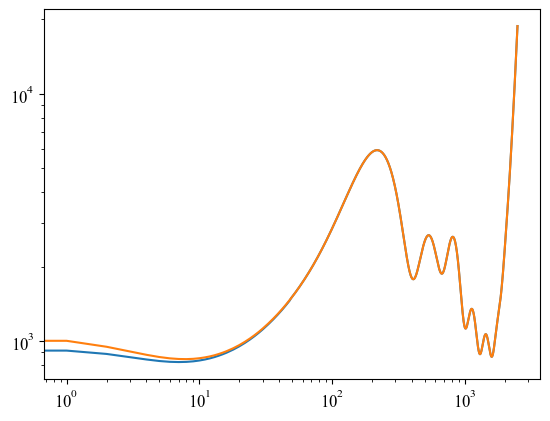

In [115]:
llow=ell[:49]
obs2=deepcopy(obs)
for i in range(49):
    l=i+2
    nm=np.round(fsky*(2*l+1))
    obs2['TT'][i]*=((nm-1)/(nm-2))**-0.5
cltt = obs2['TT']
plt.plot(cltt*ells)
plt.plot(obs['TT']*ells)
plt.yscale('log')
plt.xscale('log')
output = [compress_vec_h.dot(cltt), compress_vec_ombh2.dot(cltt), compress_vec_omch2.dot(cltt), compress_vec_As.dot(cltt),compress_vec_ns.dot(cltt)]
obs_compressed = torch.tensor(output)

In [131]:
posterior = inference.build_posterior(density_estimator)
proposal = posterior.set_default_x(obs_compressed)
posterior_samples = posterior.sample((1000000,))



Drawing 1000000 posterior samples:   0%|          | 0/1000000 [00:00<?, ?it/s]

In [39]:
print(posterior_samples)

tensor([[0.7376, 0.0229, 0.1236, 3.1238, 0.9720],
        [0.7351, 0.0216, 0.1216, 3.1154, 0.9616],
        [0.7494, 0.0225, 0.1203, 3.1193, 0.9748],
        ...,
        [0.7626, 0.0225, 0.1169, 3.1147, 0.9732],
        [0.7402, 0.0228, 0.1238, 3.1327, 0.9486],
        [0.7364, 0.0216, 0.1209, 3.1069, 0.9745]])


In [96]:
print(param_max)
print(param_min)

[0.8507075309753418, 0.0262389425188303, 0.15965238213539124, 3.158629894256592, 1.0647083520889282]
[0.5013616681098938, 0.01856084167957306, 0.08034924417734146, 2.9919726848602295, 0.8652652502059937]


In [86]:
data = np.loadtxt('/Users/aisulu/Desktop/report_code/montemcmc_files/2024-02-24_10000__1.txt')
data = np.concatenate((data,np.loadtxt('/Users/aisulu/Desktop/report_code/montemcmc_files/2024-02-25_10000__1.txt')),axis=0)
data = np.concatenate((data,np.loadtxt('/Users/aisulu/Desktop/report_code/montemcmc_files/2024-02-25_20000__3.txt')),axis=0)
data = np.concatenate((data,np.loadtxt('/Users/aisulu/Desktop/report_code/montemcmc_files/2024-02-25_20000__4.txt')),axis=0)
data = np.concatenate((data,np.loadtxt('/Users/aisulu/Desktop/report_code/montemcmc_files/2024-02-25_30000__1.txt')),axis=0)

data_reshape = []
for i in range(len(data)):
    sample = [data[i][2]-0.032-3e-3-0.0105+0.00920, (data[i][3]-0.075)/100, data[i][4]+0.011-5.775e-3+4e-3-8.25e-4, 
              np.log(10*data[i][5])-0.113-0.0175+0.0116-0.000526, data[i][6]+2e-3-0.0015]
    data_reshape.append(sample)
data_reshape = np.array(data_reshape)

Removed no burn in
Removed no burn in
Removed no burn in


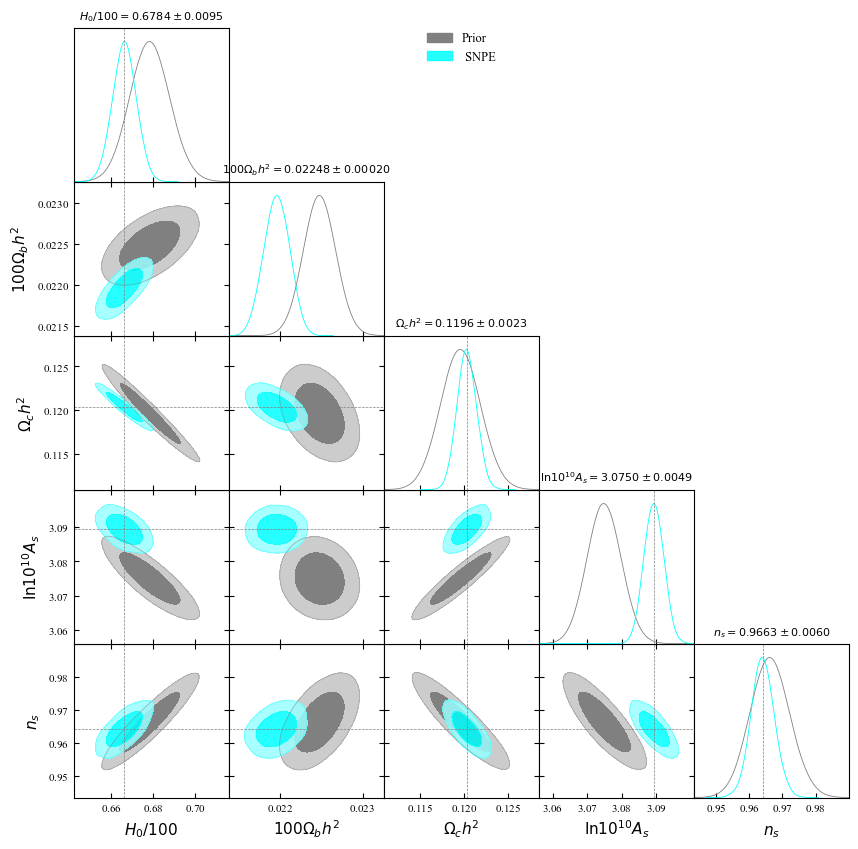

In [132]:
from getdist import plots
from getdist import MCSamples

%matplotlib inline

param_names = ["param1", "param2", 'param3', 'param4', 'param5']
param_labels = [r"H_0 / 100", r"100 \Omega_b h^2", r'\Omega_c h^2', r'\ln 10^{10} A_s', r'n_s']

snpe_1r_samples = MCSamples(samples=posterior_samples.numpy(), names=param_names, labels=param_labels)
mcmc_samples = MCSamples(samples=data_reshape, names=param_names, labels=param_labels)
prior_samples = MCSamples(samples=pars_store, names=param_names, labels=param_labels)

g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.triangle_plot([ snpe_1r_samples, mcmc_samples], filled=True, 
                contour_colors = ['grey', 'cyan', 'red'],
                legend_labels=['Prior', ' SNPE', 'MCMC'], 
                markers ={'param1':0.6663, 'param2': 2.1963, 'param3': 0.1203, 'param4':3.0893, 'param5': 0.964, 
                          'color': 'black'}, 
                title_limit = 1
                
                );

## DEFINE SNPE

In [125]:
def noise2(sample):
    cat = np.array(sample['TT'])
    CLTT=[]
    for l in range(2,2+49):
        nm=int(np.round(fsky*(2*l+1)))
        g1=np.random.randn(nm)
        almT=np.sqrt(sample['TT'][l-2])*g1
        CLTT.append((((nm))**-1 *np.sum((almT**2))))
    NN=noisevecs[np.random.randint(0,100000)]
    noise=np.concatenate((np.zeros(29+20), NN[29+20:2499]))
    cat[:49]=np.array(CLTT)
    cat=cat+noise
    return {'TT': cat[:2500]}

def snpe_sim(params):
    sim = simulator(np.array(params))
    noise_sim = noise2(sim)['TT']
    compressed = [compress_vec_h.dot(noise_sim), compress_vec_ombh2.dot(noise_sim), compress_vec_omch2.dot(noise_sim), compress_vec_As.dot(noise_sim),compress_vec_ns.dot(noise_sim)]
    return compressed

In [127]:
import pickle
with open ('posteriors_good/posterior_1_round.pkl', 'wb') as file:
    pickle.dump(posterior, file)

In [133]:
posteriors = []

simulator_sbi, prior = prepare_for_sbi(snpe_sim, prior)

posteriors = []
proposals = []
proposals.append(proposal)

num_rounds = 1

for _ in range(num_rounds):
    theta, x = simulate_for_sbi(simulator_sbi, proposal, num_simulations=1000)
    density_estimator = inference.append_simulations(
        theta, x, proposal=proposal
    ).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(obs_compressed)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running 1000 simulations.:   0%|          | 0/1000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss


AssertionError: NaN/Inf present in prior eval.

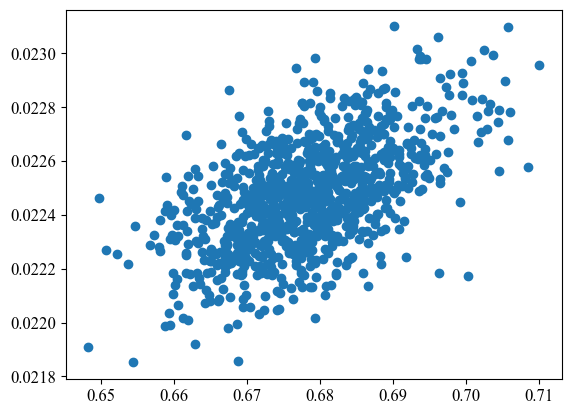

In [134]:
plt.scatter(theta[:,0], theta[:,1])

In [148]:
prior = utils.BoxUniform(low=torch.as_tensor(param_min),
                         high=torch.as_tensor(param_max))

inference = SNPE(prior=prior)

proposal = proposals[0]

theta, x = simulate_for_sbi(simulator_sbi, proposal, num_simulations=5000)

inference = inference.append_simulations(theta, x, proposal = proposal)

density_estimator = inference.train()

posterior = inference.build_posterior(density_estimator)
posteriors.append(posterior)

Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Running 5000 simulations.:   0%|          | 0/5000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 19

TypeError: argument of type 'NoneType' is not iterable

Exception ignored in: 'classy.Class.__dealloc__'
Traceback (most recent call last):
  File "classy.pyx", line 210, in classy.Class.struct_cleanup
TypeError: argument of type 'NoneType' is not iterable


 Neural network successfully converged after 64 epochs.

In [151]:
posterior = inference.build_posterior(density_estimator)
proposal_new = posterior.set_default_x(obs_compressed)
posterior_samples_new = posterior.sample((1000000,))

Drawing 1000000 posterior samples:   0%|          | 0/1000000 [00:00<?, ?it/s]

Removed no burn in
Removed no burn in
Removed no burn in


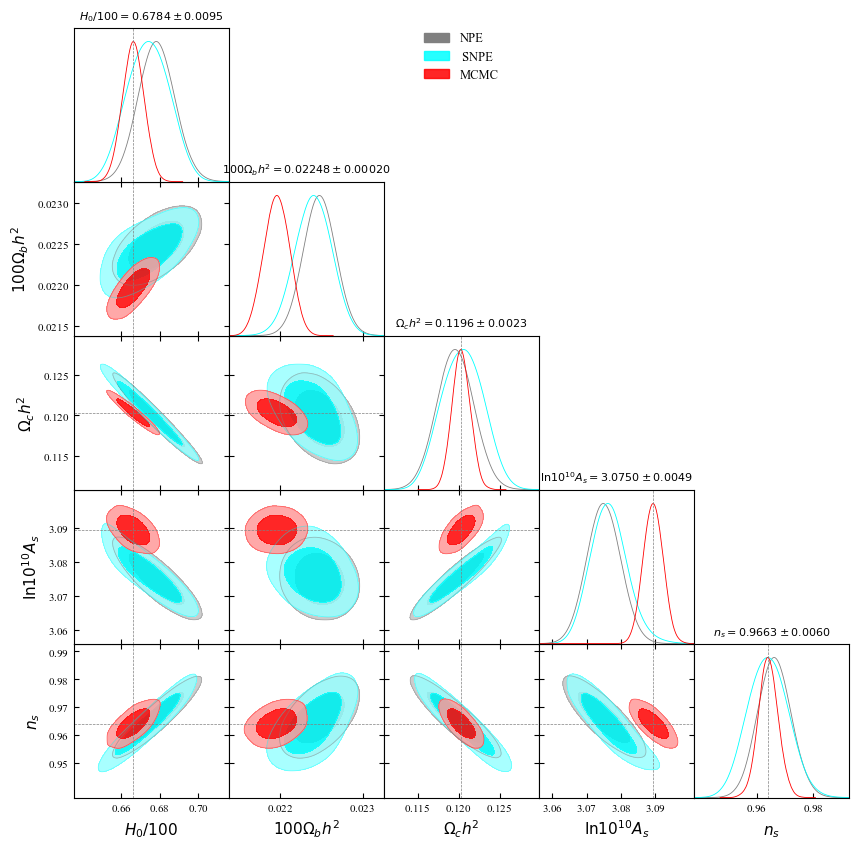

In [152]:
from getdist import plots
from getdist import MCSamples

%matplotlib inline

param_names = ["param1", "param2", 'param3', 'param4', 'param5']
param_labels = [r"H_0 / 100", r"100 \Omega_b h^2", r'\Omega_c h^2', r'\ln 10^{10} A_s', r'n_s']

snpe_1r_samples = MCSamples(samples=posterior_samples.numpy(), names=param_names, labels=param_labels)
snpe_2r_samples = MCSamples(samples=posterior_samples_new.numpy(), names=param_names, labels=param_labels)
mcmc_samples = MCSamples(samples=data_reshape, names=param_names, labels=param_labels)

g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.triangle_plot([ snpe_1r_samples, snpe_2r_samples,mcmc_samples], filled=True, 
                contour_colors = ['grey', 'cyan', 'red'],
                legend_labels=['NPE', ' SNPE', 'MCMC'], 
                markers ={'param1':0.6663, 'param2': 2.1963, 'param3': 0.1203, 'param4':3.0893, 'param5': 0.964, 
                          'color': 'black'}, 
                title_limit = 1
                
                );

In [149]:
np.save('sims_pars_saved/sims/second.npy', x)
np.save('sims_pars_saved/pars/second.npy', theta)

In [147]:
print(proposals)

[DirectPosterior sampler for potential_fn=<PosteriorBasedPotential>]


# Try again with no Nltt

In [154]:
def simulator_nonltt(v):
    V=np.around(v, decimals=6)
    h, omega_b, omega_cdm, lnAs,n_s=V[0],V[1],V[2],V[3],V[4]
    A_s=np.exp(lnAs)/ 1.e10
    params = {
        'output': 'tCl pCl lCl',
        'l_max_scalars': lmax,
        'lensing': 'yes',
        'h': h,
        'omega_b': omega_b,
        'omega_cdm': omega_cdm,
        'A_s': A_s,
        'n_s': n_s,
    }
    cosmo = Class()
    cosmo.set(params)
    try:
        cosmo.compute(['lensing'])
        cls = cosmo.lensed_cl(lmax)
        T=cosmo.T_cmb()
        cosmo.struct_cleanup()
        cosmo.empty()
        return dict(TT=cls['tt'][ell]*(T*1.e6)**2)
    except Exception as e:
        print("a simulation failed!")
        print(f"An error occurred: {e}")
        return dict(TT=np.nan)
    
pl=[0.676, 0.0224, 0.12, 3.0753, 0.965]
obs = simulator(pl)

covmat=np.diag(obs['TT']**2)*2/((2*ell+1)*fsky)
icovmat=np.linalg.inv(covmat)

noisevecs = np.random.multivariate_normal(np.zeros(2499),covmat,size=100000)

def noise_nonltt(sim):
    cat = np.array(sim['TT'])
    CLTT=[]
    for l in range(2,2+49):
        nm=int(np.round(fsky*(2*l+1)))
        g1=np.random.randn(nm)
        almT=np.sqrt(sim['TT'][l-2])*g1
        CLTT.append((((nm))**-1 *np.sum((almT**2))))
    NN=noisevecs[np.random.randint(0,100000)]
    noise=np.concatenate((np.zeros(29+20), NN[29+20:2499]))
    cat[:49]=np.array(CLTT)
    cat=cat+noise
    return {'TT': cat[:2500]}

In [157]:
def add_noise(sim):
    cat = np.array(sim)
    CLTT=[]
    for l in range(2,2+49):
        nm=int(np.round(fsky*(2*l+1)))
        g1=np.random.randn(nm)
        almT=np.sqrt(sim[l-2])*g1
        CLTT.append((((nm))**-1 *np.sum((almT**2))))
    NN=noisevecs[np.random.randint(0,100000)]
    noise=np.concatenate((np.zeros(29+20), NN[29+20:2499]))
    cat[:49]=np.array(CLTT)
    cat=cat+noise
    return cat[:2500]

In [156]:
def snpe_sim_nonltt(params):
    sim = simulator_nonltt(np.array(params))
    noise_sim = noise_nonltt(sim)['TT']
    compressed = [compress_vec_h.dot(noise_sim), compress_vec_ombh2.dot(noise_sim), compress_vec_omch2.dot(noise_sim), compress_vec_As.dot(noise_sim),compress_vec_ns.dot(noise_sim)]
    return compressed

In [171]:
path_to_bank = '/Users/aisulu/Desktop/gcloud_files/'
if path_to_bank not in sys.path:
    sys.path.append(path_to_bank)

cl_bank = np.load('/Users/aisulu/Desktop/gcloud_files/cls.npy')
cl_hat_bank =  np.load('/Users/aisulu/Desktop/gcloud_files/cl_hats.npy')
pars_bank = np.load('/Users/aisulu/Desktop/report_code/params.npy')

In [164]:
from tqdm import tqdm
cl_bank_noise= []
for i in tqdm(range(len(cl_bank))):
    cl_bank_noise.append(add_noise(cl_bank[i][:2499]/ells))
cl_bank_noise = np.array(cl_bank_noise)

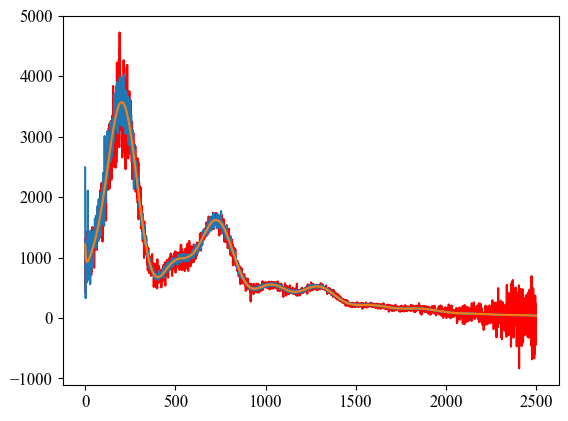

In [172]:
plt.plot(cl_bank_noise[0]*ells, color = 'red')
plt.plot(cl_hat_bank[0][:2499])
plt.plot(cl_bank[0][:2499])


In [ ]:
posteriors = []

simulator_sbi, prior = prepare_for_sbi(snpe_sim, prior)

posteriors = []
proposals = []
proposals.append(proposal)



theta, x = simulate_for_sbi(simulator_sbi, proposal, num_simulations=1000)
density_estimator = inference.append_simulations(theta, x, proposal=proposal).train()
posterior = inference.build_posterior(density_estimator)
posteriors.append(posterior)
proposal = posterior.set_default_x(obs_compressed)

In [173]:
print(posterior_samples_new)

tensor([[0.6706, 0.0221, 0.1206, 3.0750, 0.9612],
        [0.6812, 0.0227, 0.1191, 3.0766, 0.9605],
        [0.6874, 0.0225, 0.1172, 3.0700, 0.9726],
        ...,
        [0.6953, 0.0227, 0.1161, 3.0699, 0.9761],
        [0.6684, 0.0224, 0.1218, 3.0803, 0.9577],
        [0.6727, 0.0225, 0.1211, 3.0785, 0.9625]])


In [176]:
np.save('snpe_samples_bad_eh.npy', posterior_samples_new)

In [178]:
print(len(theta))

5000


Removed no burn in


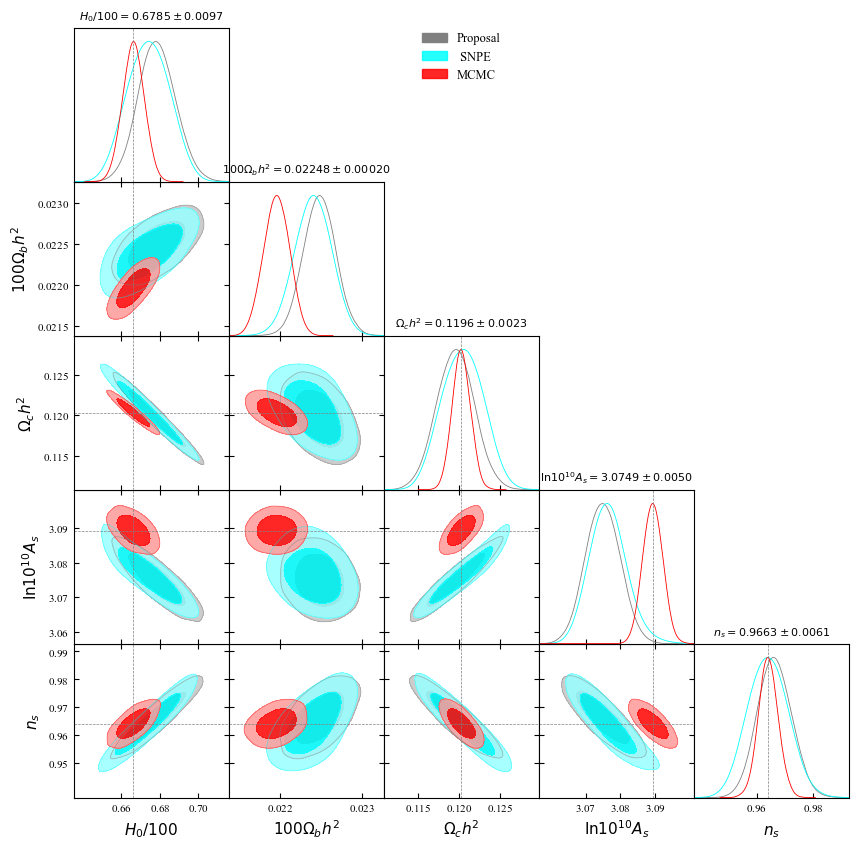

In [181]:

prior_samples = MCSamples(samples=theta.numpy(), names=param_names, labels=param_labels)

g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.triangle_plot([ prior_samples, snpe_2r_samples,mcmc_samples], filled=True, 
                contour_colors = ['grey', 'cyan', 'red'],
                legend_labels=['Proposal', ' SNPE', 'MCMC'], 
                markers ={'param1':0.6663, 'param2': 2.1963, 'param3': 0.1203, 'param4':3.0893, 'param5': 0.964, 
                          'color': 'black'}, 
                title_limit = 1
                
                );

In [194]:
infernce_snpe = SNPE(prior=prior)
infernce_snpe=infernce_snpe.append_simulations(theta, x, proposal=theta)

density_estimator_snpe = infernce_snpe.train(training_batch_size=64, learning_rate=1e-4)
posterior_snpe = infernce_snpe.build_posterior(density_estimator_snpe)
posteriors.append(posterior_snpe)
proposal = posterior_snpe.set_default_x(obs_compressed)

/Users/aisulu/anaconda3/envs/myenv/lib/python3.8/site-packages/sbi/inference/snpe/snpe_base.py:601: UserWarning: The proposal you passed is neither the prior nor a `NeuralPosterior` object. If you are an expert user and did so for research purposes, this is fine. If not, you might be doing something wrong: feel free to create an issue on Github.
  warn(


Using SNPE-C with atomic loss


 Neural network successfully converged after 83 epochs.

In [197]:
posterior_snpe_samples = posterior_snpe.sample((100000,))

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

Removed no burn in


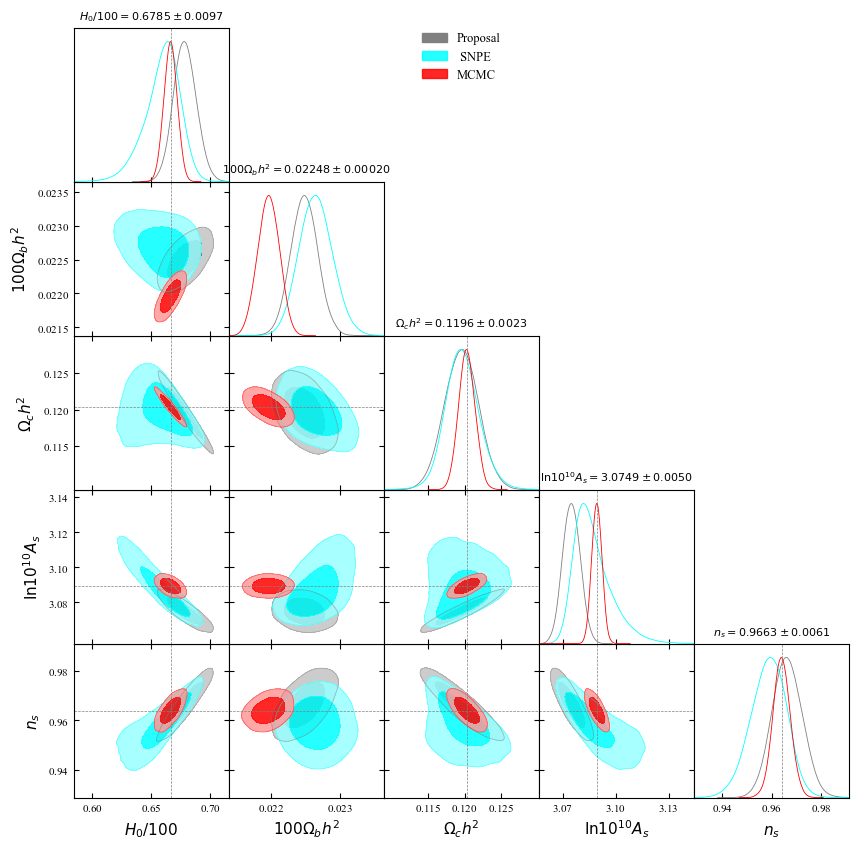

In [198]:

snpe_2r_v2 = MCSamples(samples=posterior_snpe_samples.numpy(), names=param_names, labels=param_labels)
g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.triangle_plot([ prior_samples, snpe_2r_v2,mcmc_samples], filled=True, 
                contour_colors = ['grey', 'cyan', 'red'],
                legend_labels=['Proposal', ' SNPE', 'MCMC'], 
                markers ={'param1':0.6663, 'param2': 2.1963, 'param3': 0.1203, 'param4':3.0893, 'param5': 0.964, 
                          'color': 'black'}, 
                title_limit = 1
                
                );

In [199]:
dl_bank = np.load('/Users/aisulu/Desktop/gcloud_files/cls.npy')
pars_bank = np.load('/Users/aisulu/Desktop/report_code/params.npy')

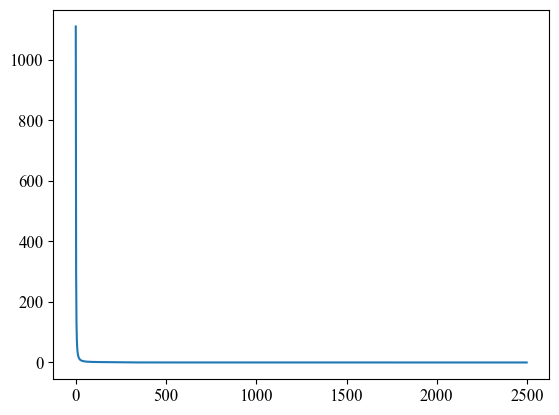

In [201]:
plt.plot(obs["TT"])

In [218]:
def compress (dls):
    cltt = dls/ells
    output = [compress_vec_h.dot(cltt), compress_vec_ombh2.dot(cltt), compress_vec_omch2.dot(cltt), compress_vec_As.dot(cltt),compress_vec_ns.dot(cltt)]
    return output

x = torch.tensor([compress(dl_bank[:, :2499][i]) for i in range(len(dl_bank))], dtype = torch.float32)
theta = torch.tensor(pars_bank, dtype = torch.float32)

mins = np.array([50, 0.01, 0.01, 1.5, 0.8])
maxs = np.array([90, 0.05, 0.5, 3.5, 1])

prior_other = utils.BoxUniform(low=torch.as_tensor(mins),
                         high=torch.as_tensor(maxs))

infernce_snpe = SNPE(prior=prior_other)
infernce_snpe=infernce_snpe.append_simulations(theta[:50000], x[:50000])

obs_uncompress = torch.tensor(compress(simulator_nonltt(pl)['TT']*ells))
density_estimator_snpe = infernce_snpe.train()
posterior_snpe = infernce_snpe.build_posterior(density_estimator_snpe)
posteriors.append(posterior_snpe)
proposal = posterior_snpe.set_default_x(obs_uncompress)
posterior_snpe_samples = posterior_snpe.sample((100000,))

 Training neural network. Epochs trained: 250

KeyboardInterrupt: 

In [210]:
data = np.loadtxt('/Users/aisulu/Desktop/report_code/montemcmc_files/2024-02-24_10000__1.txt')
data = np.concatenate((data,np.loadtxt('/Users/aisulu/Desktop/report_code/montemcmc_files/2024-02-25_10000__1.txt')),axis=0)
data = np.concatenate((data,np.loadtxt('/Users/aisulu/Desktop/report_code/montemcmc_files/2024-02-25_20000__3.txt')),axis=0)
data = np.concatenate((data,np.loadtxt('/Users/aisulu/Desktop/report_code/montemcmc_files/2024-02-25_20000__4.txt')),axis=0)
data = np.concatenate((data,np.loadtxt('/Users/aisulu/Desktop/report_code/montemcmc_files/2024-02-25_30000__1.txt')),axis=0)

data_reshape = []
for i in range(len(data)):
    sample = [(data[i][2]-0.032-3e-3-0.0105+0.00920)*100, (data[i][3]-0.075)/100, data[i][4]+0.011-5.775e-3+4e-3-8.25e-4, 
              np.log(10*data[i][5])-0.113-0.0175+0.0116-0.000526, data[i][6]+2e-3-0.0015]
    data_reshape.append(sample)
data_reshape = np.array(data_reshape)

Removed no burn in
Removed no burn in


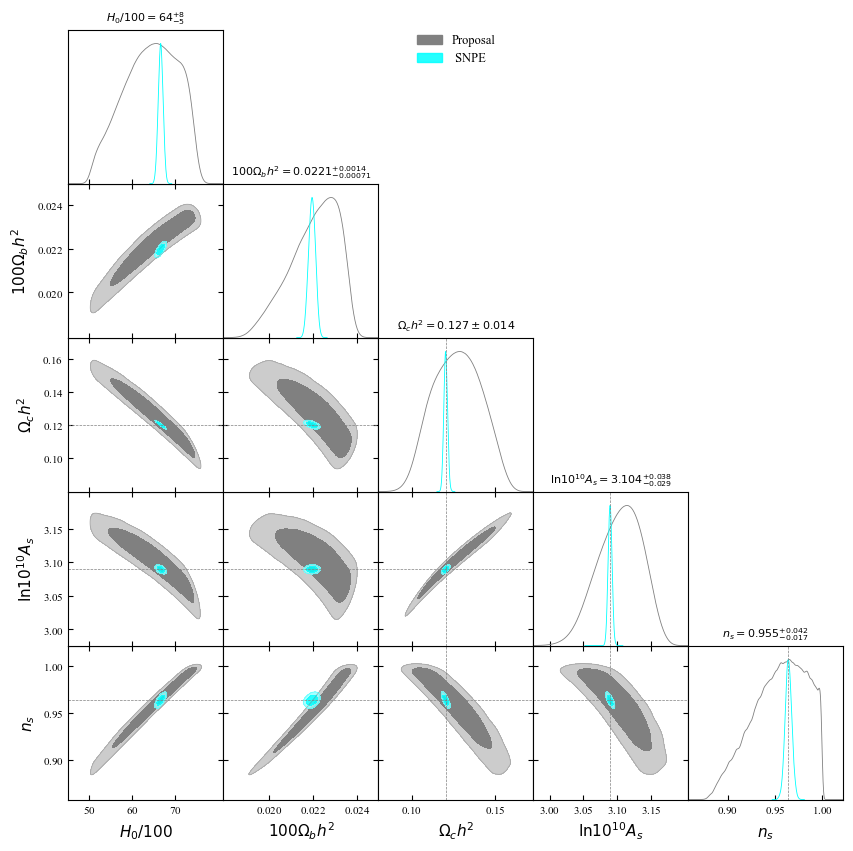

In [217]:
snpe_2r_v2 = MCSamples(samples=posterior_snpe_samples.numpy(), names=param_names, labels=param_labels)
mcmc_samples = MCSamples(samples=data_reshape, names=param_names, labels=param_labels)
g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.triangle_plot([ snpe_2r_v2,mcmc_samples], filled=True, 
                contour_colors = ['grey', 'red', 'red'],
                legend_labels=['Proposal', ' MCMC', 'MCMC'], 
                markers ={'param1':0.6663, 'param2': 2.1963, 'param3': 0.1203, 'param4':3.0893, 'param5': 0.964, 
                          'color': 'black'}, 
                title_limit = 1
                
                );

Removed no burn in
Removed no burn in
Removed no burn in


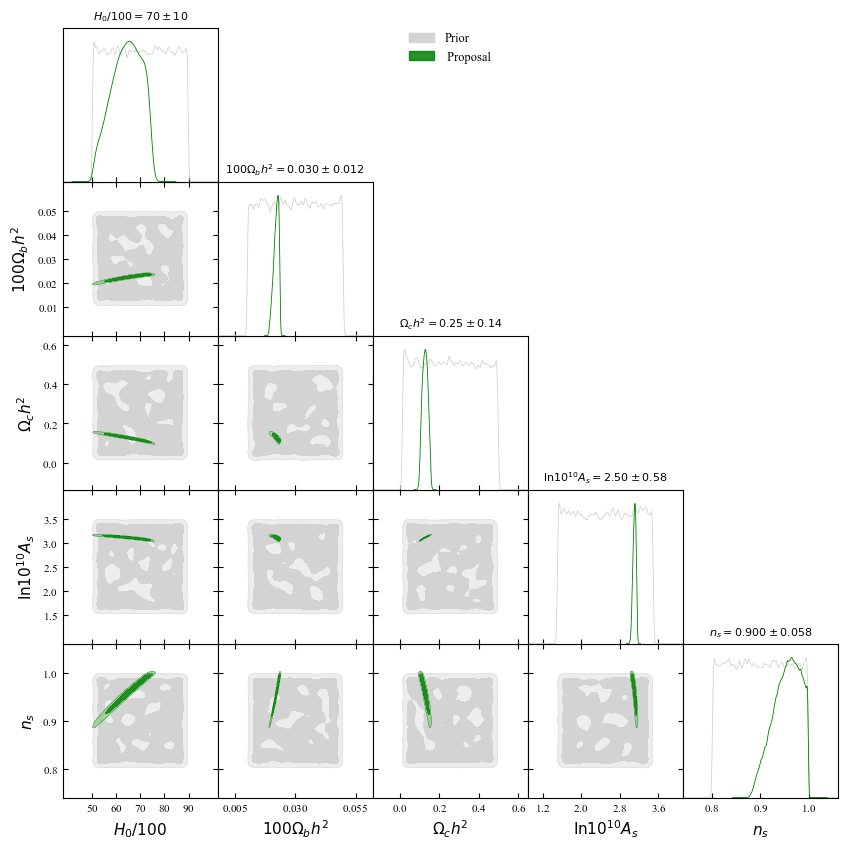

In [225]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 20

snpe_2r_v2 = MCSamples(samples=posterior_snpe_samples.numpy(), names=param_names, labels=param_labels)
mcmc_samples = MCSamples(samples=data_reshape, names=param_names, labels=param_labels)
prior_samples = MCSamples(samples=pars_bank, names=param_names, labels=param_labels)
g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.triangle_plot([ prior_samples, snpe_2r_v2], filled=True, 
                contour_colors = ['lightgrey', 'green', 'red'],
                legend_labels=['Prior', ' Proposal', 'MCMC'], 
                title_limit = 1
                
                );

plt.savefig('/Users/aisulu/Desktop/report_code/plots/leakage.pdf')